In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from deap import base, creator, tools, algorithms
import random

# Assuming these are defined in your original code
from wavefn import WaveFunction

# Hyperparameters
batch_size = 8
block_size = 16
max_iter = 500
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vocab_size = 12  # Assuming this is correct based on your original tokens

tokens = ['0','1','2','3','4','5','6','7','8','9','s','e']
stoi = { ch:i for i, ch in enumerate(tokens)}
itos = { i:ch for i, ch in enumerate(tokens)}
enc = lambda s: [stoi[str(c)] for c in s]
dec = lambda l: ''.join([itos[i] for i in l[1:-1]])  # Skipping the first and last items ('s' and 'e')

# Wave generation functions (from your original code)
def generate_random_wave_profile(size):
    return ((np.random.rand(size)*10).astype(int))

def simulate_wave_sequence(batch_size, size):
    initial_profiles = [generate_random_wave_profile(size) for _ in range(batch_size)]
    final_profiles = []
    for profile in initial_profiles:
        transformed_profile = wave_fn.simulate_wave_equation(profile)
        transformed_profile_clipped = np.clip(transformed_profile, 0, 9).astype(int)
        transformed_profile_as_str = 's' + ''.join(map(str, transformed_profile_clipped.tolist())) + 'e'
        final_profiles.append(transformed_profile_as_str)
    return initial_profiles, final_profiles

def get_batch(batch_size, size, block_size):
    initial_profiles, final_profiles = simulate_wave_sequence(batch_size, size)
    X = torch.tensor([enc(profile)[:block_size] for profile in initial_profiles], dtype=torch.long)
    Y = torch.tensor([enc(profile)[:block_size] for profile in final_profiles], dtype=torch.long)
    return X.to(device), Y.to(device)

# Simplified model components
class CoPEPositionalEmbedding(nn.Module):
    def __init__(self, n_embed, max_len):
        super().__init__()
        self.fc = nn.Linear(n_embed, n_embed)

    def forward(self, tok_emb):
        seq_len = tok_emb.size(1)
        position_indices = torch.arange(seq_len, device=tok_emb.device).unsqueeze(0).repeat(tok_emb.size(0), 1)
        position_encoded = self.fc(tok_emb + self.fc(position_indices.float().unsqueeze(-1).expand(-1, -1, tok_emb.size(-1))))
        return position_encoded

class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        self.sa = nn.MultiheadAttention(n_embed, n_head)
        self.ffwd = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.GELU(),
            nn.Linear(4 * n_embed, n_embed)
        )
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x), self.ln1(x), self.ln1(x))[0]
        x = x + self.ffwd(self.ln2(x))
        return x

class SmallLLM(nn.Module):
    def __init__(self, vocab_size, n_embed, n_head, n_layer):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embed)
        self.position_embedding = CoPEPositionalEmbedding(n_embed, block_size)
        self.blocks = nn.Sequential(*[Block(n_embed, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx):
        tok_emb = self.token_embedding(idx)
        pos_emb = self.position_embedding(tok_emb)
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits

class LLMEnsemble(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models)
        self.weights = nn.Parameter(torch.ones(len(models)) / len(models))

    def forward(self, idx):
        outputs = [model(idx) for model in self.models]
        weighted_sum = sum(w * out for w, out in zip(self.weights, outputs))
        return weighted_sum

# Evolutionary Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def generate_random_architecture():
    return {
        'n_embed': random.choice([32, 48, 64, 80, 96, 112, 128, 144, 160]),
        'n_head': random.choice([1, 2, 4, 8]),
        'n_layer': random.choice([1, 2, 4, 8])
    }

def mutate(individual):
    idx = random.randint(0, len(individual) - 1)
    individual[idx] = generate_random_architecture()
    return individual,

def mate(ind1, ind2):
    return tools.cxTwoPoint(ind1, ind2)

def evaluate(individual):
    models = [SmallLLM(vocab_size, **arch) for arch in individual]
    ensemble = LLMEnsemble(models).to(device)
    optimizer = torch.optim.AdamW(ensemble.parameters(), lr=1e-4)
    
    total_loss = 0
    for _ in range(10):  # Short training
        xb, yb = get_batch(batch_size, 64, block_size)
        logits = ensemble(xb)
        loss = F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return (1 / (total_loss / 10),)  # Return fitness (higher is better)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initRepeat, creator.Individual, generate_random_architecture, n=5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", mate)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

def train_best_ensemble(best_individual, epochs=5):
    models = [SmallLLM(vocab_size, **arch) for arch in best_individual]
    ensemble = LLMEnsemble(models).to(device)
    optimizer = torch.optim.AdamW(ensemble.parameters(), lr=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

    val_batch_size = batch_size  # Define validation batch size
    max_norm = 1  # Gradient clipping value
    eval_interval = 500  # Evaluation interval

    for epoch in range(epochs):
        total_loss = 0
        for iter in range(max_iter // epochs):
            ensemble.train()
            xb, yb = get_batch(batch_size, 64, block_size)
            logits = ensemble(xb)
            loss = F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1))
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(ensemble.parameters(), max_norm)
            optimizer.step()
            total_loss += loss.item()

            if iter % eval_interval == 0:
                ensemble.eval()
                with torch.no_grad():
                    xv, yv = get_batch(val_batch_size, 64, block_size)
                    val_logits = ensemble(xv)
                    val_loss = F.cross_entropy(val_logits.view(-1, vocab_size), yv.view(-1))
                    print(f"Epoch {epoch}, Iteration {iter}: Training Loss = {loss.item()}, Validation Loss = {val_loss.item()}")
                ensemble.train()

        avg_loss = total_loss / (max_iter // epochs)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss}")
        scheduler.step(avg_loss)

    return ensemble


def main():
    global best_individual
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=10, stats=stats, halloffame=hof, verbose=True)

    print("Evolution complete")
    best_individual = hof[0]
    print("Best individual:", best_individual)

    print("Training best ensemble...")
    best_ensemble = train_best_ensemble(best_individual)
    
    print("Training complete")
    return best_ensemble

if __name__ == "__main__":
    # Initialize WaveFunction (assuming this is from your original code)
    wave_length = 32
    c = 1.0
    dx = 0.1
    dt = 0.1
    wave_fn = WaveFunction(c, dx, dt)

    # Run the evolutionary process and train the best ensemble
    best_model = main()

    # Save the model
    torch.save(best_model.state_dict(), 'models/best_evolutionary_ensemble.pth')
    print("Model saved as 'best_evolutionary_ensemble.pth'")

gen	nevals	avg     	min     	max     
0  	50    	0.439817	0.408124	0.471172
1  	38    	0.443609	0.421586	0.472563
2  	39    	0.45028 	0.423496	0.475205
3  	32    	0.457145	0.435879	0.475205
4  	31    	0.461302	0.431229	0.475205
5  	40    	0.46234 	0.441386	0.485888
6  	48    	0.45957 	0.437393	0.476585
7  	35    	0.460021	0.437398	0.476585
8  	44    	0.462958	0.44758 	0.485741
9  	38    	0.462012	0.440283	0.485741
10 	42    	0.460384	0.437959	0.480047
Evolution complete
Best individual: [{'n_embed': 144, 'n_head': 8, 'n_layer': 8}, {'n_embed': 160, 'n_head': 1, 'n_layer': 2}, {'n_embed': 160, 'n_head': 1, 'n_layer': 8}, {'n_embed': 160, 'n_head': 4, 'n_layer': 2}, {'n_embed': 128, 'n_head': 8, 'n_layer': 2}]
Training best ensemble...
Epoch 0, Iteration 0: Training Loss = 2.5392637252807617, Validation Loss = 2.5170538425445557
Epoch 1, Average Loss: 2.142045042514801
Epoch 1, Iteration 0: Training Loss = 1.9719122648239136, Validation Loss = 1.8154058456420898
Epoch 2, Average Loss: 1.

Input is: [6 4 5 7 1 0 0 1 5 9 9 5 3 6 3 6]
Decoded Output: 457100159953636000000000000000
Generated Output: 0000000000000
Wavefn Output: [2 4 2 4 4 4 2 0 0 0 0 4 9 9 4 2]
Decoded values:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


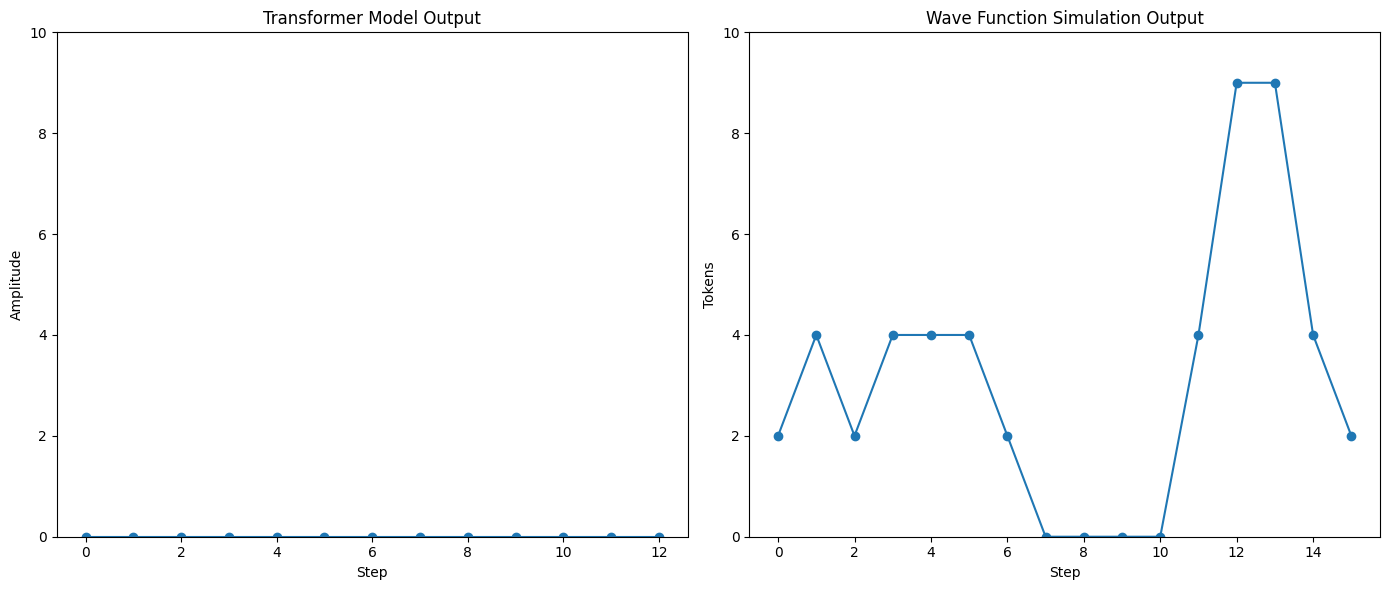

In [14]:
import matplotlib.pyplot as plt
import torch

models = [SmallLLM(vocab_size, **arch) for arch in best_individual]
model = LLMEnsemble(models).to(device)

# # Load the state dictionary
model.load_state_dict(torch.load('models/best_evolutionary_ensemble.pth'))
model.eval()

# Generate input
input_length = 16
input = (np.random.rand(input_length) * 10).astype(int)
print(f"Input is: {input}")
encoded_input = enc(input)

# Convert to a tensor and add a batch dimension (assuming your model expects a batch)
input_tensor = torch.tensor([encoded_input], dtype=torch.long).to(device)
max_new_tokens = input_length  # Define how many new tokens you want to generate

# Implement a generate function if not already defined in your model
def generate(model, idx, max_new_tokens):
    model.eval()
    with torch.no_grad():
        for _ in range(max_new_tokens):
            logits = model(idx)
            next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
            idx = torch.cat((idx, next_token), dim=1)
    return idx

# Generate output
output_tensor = generate(model, input_tensor, max_new_tokens=max_new_tokens)
decoded_output = dec(output_tensor[0].tolist())  # Assuming you're interested in the first item in the batch
generated_output = decoded_output[input_length+1:].split('e')[0]
sim_wave_output = wave_fn.simulate_wave_equation(input)
print("Decoded Output:", decoded_output)
print("Generated Output:", generated_output)
print("Wavefn Output:", sim_wave_output)

# Plotting
decoded_values = [int(char) for char in generated_output]

print("Decoded values: ", decoded_values)
global_min = 0
global_max = 9

plt.figure(figsize=(14, 6))

# Plot for the Transformer Model Output
plt.subplot(1, 2, 1)
plt.plot(decoded_values, marker='o', linestyle='-')
plt.title('Transformer Model Output')
plt.xlabel('Step')
plt.ylabel('Amplitude')
plt.ylim(global_min, global_max + 1)  # Set Y-axis limits to be the same for both plots

# Plot for the Wave Function Simulation Output
plt.subplot(1, 2, 2)
plt.plot(sim_wave_output, marker='o', linestyle='-')
plt.title('Wave Function Simulation Output')
plt.xlabel('Step')
plt.ylabel('Tokens')
plt.ylim(global_min, global_max + 1)  # Set Y-axis limits to be the same for both plots

plt.tight_layout()
plt.show()
